In [1]:
# ==== System and Path Setup ====
import os
import sys

# Add path to parent directory (Experiments/) so utils is treated as a package
os.chdir('/path/to/concept_inversion/Experiments/')
sys.path.append(os.path.abspath(".."))

# ==== Core Libraries ====
import torch
import random
import pandas as pd
from tqdm import tqdm
from transformers import MllamaForConditionalGeneration, AutoProcessor

# ==== Import Utility Modules ====
from utils import (
    gt_concept_segmentation_utils,
    general_utils,
    text_visualization_utils,
    quant_concept_evals_utils
)

# Optional: Reload for development use
import importlib
importlib.reload(gt_concept_segmentation_utils)
importlib.reload(general_utils)
importlib.reload(text_visualization_utils)
importlib.reload(quant_concept_evals_utils)

# ==== Function-Level Imports (optional for convenience) ====
# from utils.compute_concepts_utils import (
#     plot_train_history
# )

from utils.gt_concept_segmentation_utils import (
    map_concepts_to_token_indices, sort_mapping_by_split,
    compute_attention_masks, map_sentence_to_concept_gt,
    print_paragraph_or_sentence_gt_examples
)

from utils.general_utils import (
    retrieve_topn_samples, load_text
)

# from utils.text_visualization_utils import (
#     # flatten_token_list, plot_sentence_similarity_heatmap, plot_most_aligned_tokens,
#     plot_tokens_in_context_byconcept, plot_all_concept_activations_on_sentence,
#     plot_most_aligned_sentences, plot_tokens_by_activation_and_gt, plot_binarized_token_activations_with_raw_heatmap,
#     filter_and_print_concept_texts, plot_binarized_multiconcept_text, plot_supertokens_on_heatmaps, plot_multi_concept_heatmaps
# )

from utils.quant_concept_evals_utils import (
    detect_then_invert_metrics_over_percentiles, concept_heatmap,
    compute_cossim_hist_stats, plot_cosine_similarity_histograms, plot_precision_recall_curves_overlay
)
from utils.memory_management_utils import ChunkedEmbeddingLoader, ChunkedActivationLoader
from utils.filter_datasets_utils import filter_concept_list

In [29]:
# my_token = os.environ.get('HF_TOKEN')
# from huggingface_hub import notebook_login
# notebook_login()

In [7]:
# model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
# MODEL = MllamaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")
# PROCESSOR = AutoProcessor.from_pretrained(model_id)
MODEL_NAME = 'Llama'
MODEL_INPUT_SIZE = ('text', 'text')

In [56]:
MODEL_NAME = 'Gemma'
MODEL_INPUT_SIZE = ('text', 'text2')

In [14]:
MODEL_NAME = 'Qwen'
MODEL_INPUT_SIZE = ('text', 'text3')

# Choose Sample Type

In [133]:
SAMPLE_TYPE = 'cls'

In [3]:
SAMPLE_TYPE = 'patch'

# Load Files

In [3]:
DATASET_NAME = 'Sarcasm'

In [4]:
DATASET_NAME = 'iSarcasm'

In [5]:
DATASET_NAME = 'GoEmotions'

In [15]:
PERCENT_THRU_MODEL = 100

EMBEDDINGS_FILE = f'{MODEL_NAME}_{SAMPLE_TYPE}_embeddings_percentthrumodel_{PERCENT_THRU_MODEL}.pt'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SCRATCH_DIR = '/path/to/scratch/'

# Compute Attention Masks for Tokens

In [16]:
# compute_attention_masks(all_text, PROCESSOR, DATASET_NAME, MODEL_INPUT_SIZE)
tokens_list = torch.load(f'GT_Samples/{DATASET_NAME}/tokens_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
relevant_tokens = torch.load(f'GT_Samples/{DATASET_NAME}/patches_w_image_mask_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
token_counts_per_sentence = torch.load(f'GT_Samples/{DATASET_NAME}/token_counts_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
# flat_tokens_list = flatten_token_list(tokens_list)

In [17]:
print(tokens_list[0])
print(len(tokens_list))
print(relevant_tokens.shape)
print(token_counts_per_sentence[0])

['I', 'âĢĻm', 'Ġreally', 'Ġsorry', 'Ġabout', 'Ġyour', 'Ġsituation', 'Ġ:(', 'ĠAlthough', 'ĠI', 'Ġlove', 'Ġthe', 'Ġnames', 'ĠS', 'app', 'h', 'ira', ',', 'ĠCir', 'illa', ',', 'Ġand', 'ĠScarlett', '!', 'ĠThe', 'Ġmeeting', 'Ġagenda', 'Ġfor', 'Ġtomorrow', 'Ġcovers', 'Ġthe', 'Ġupcoming', 'Ġproject', 'Ġmilestones', '.']
5427
torch.Size([181617])
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


# Embed Text Samples

In [18]:
# if SAMPLE_TYPE == 'patch':
#     embeds_dic = compute_batch_embeddings(all_text, get_llama_text_patch_embeddings, MODEL, PROCESSOR, DEVICE, 
#                                         percent_thru_model=PERCENT_THRU_MODEL, dataset_name=DATASET_NAME, 
#                                         model_input_size=MODEL_INPUT_SIZE, embeddings_file=EMBEDDINGS_FILE,
#                                           batch_size=5)
# else:
#     embeds_dic = compute_batch_embeddings(all_text, get_llama_text_cls_embeddings, MODEL, PROCESSOR, DEVICE, 
#                                         percent_thru_model=PERCENT_THRU_MODEL, dataset_name=DATASET_NAME, 
#                                         model_input_size=MODEL_INPUT_SIZE, embeddings_file=EMBEDDINGS_FILE,
#                                           batch_size=5)

embeds_loader = ChunkedEmbeddingLoader(DATASET_NAME, EMBEDDINGS_FILE, SCRATCH_DIR, DEVICE)

## Sanity Check

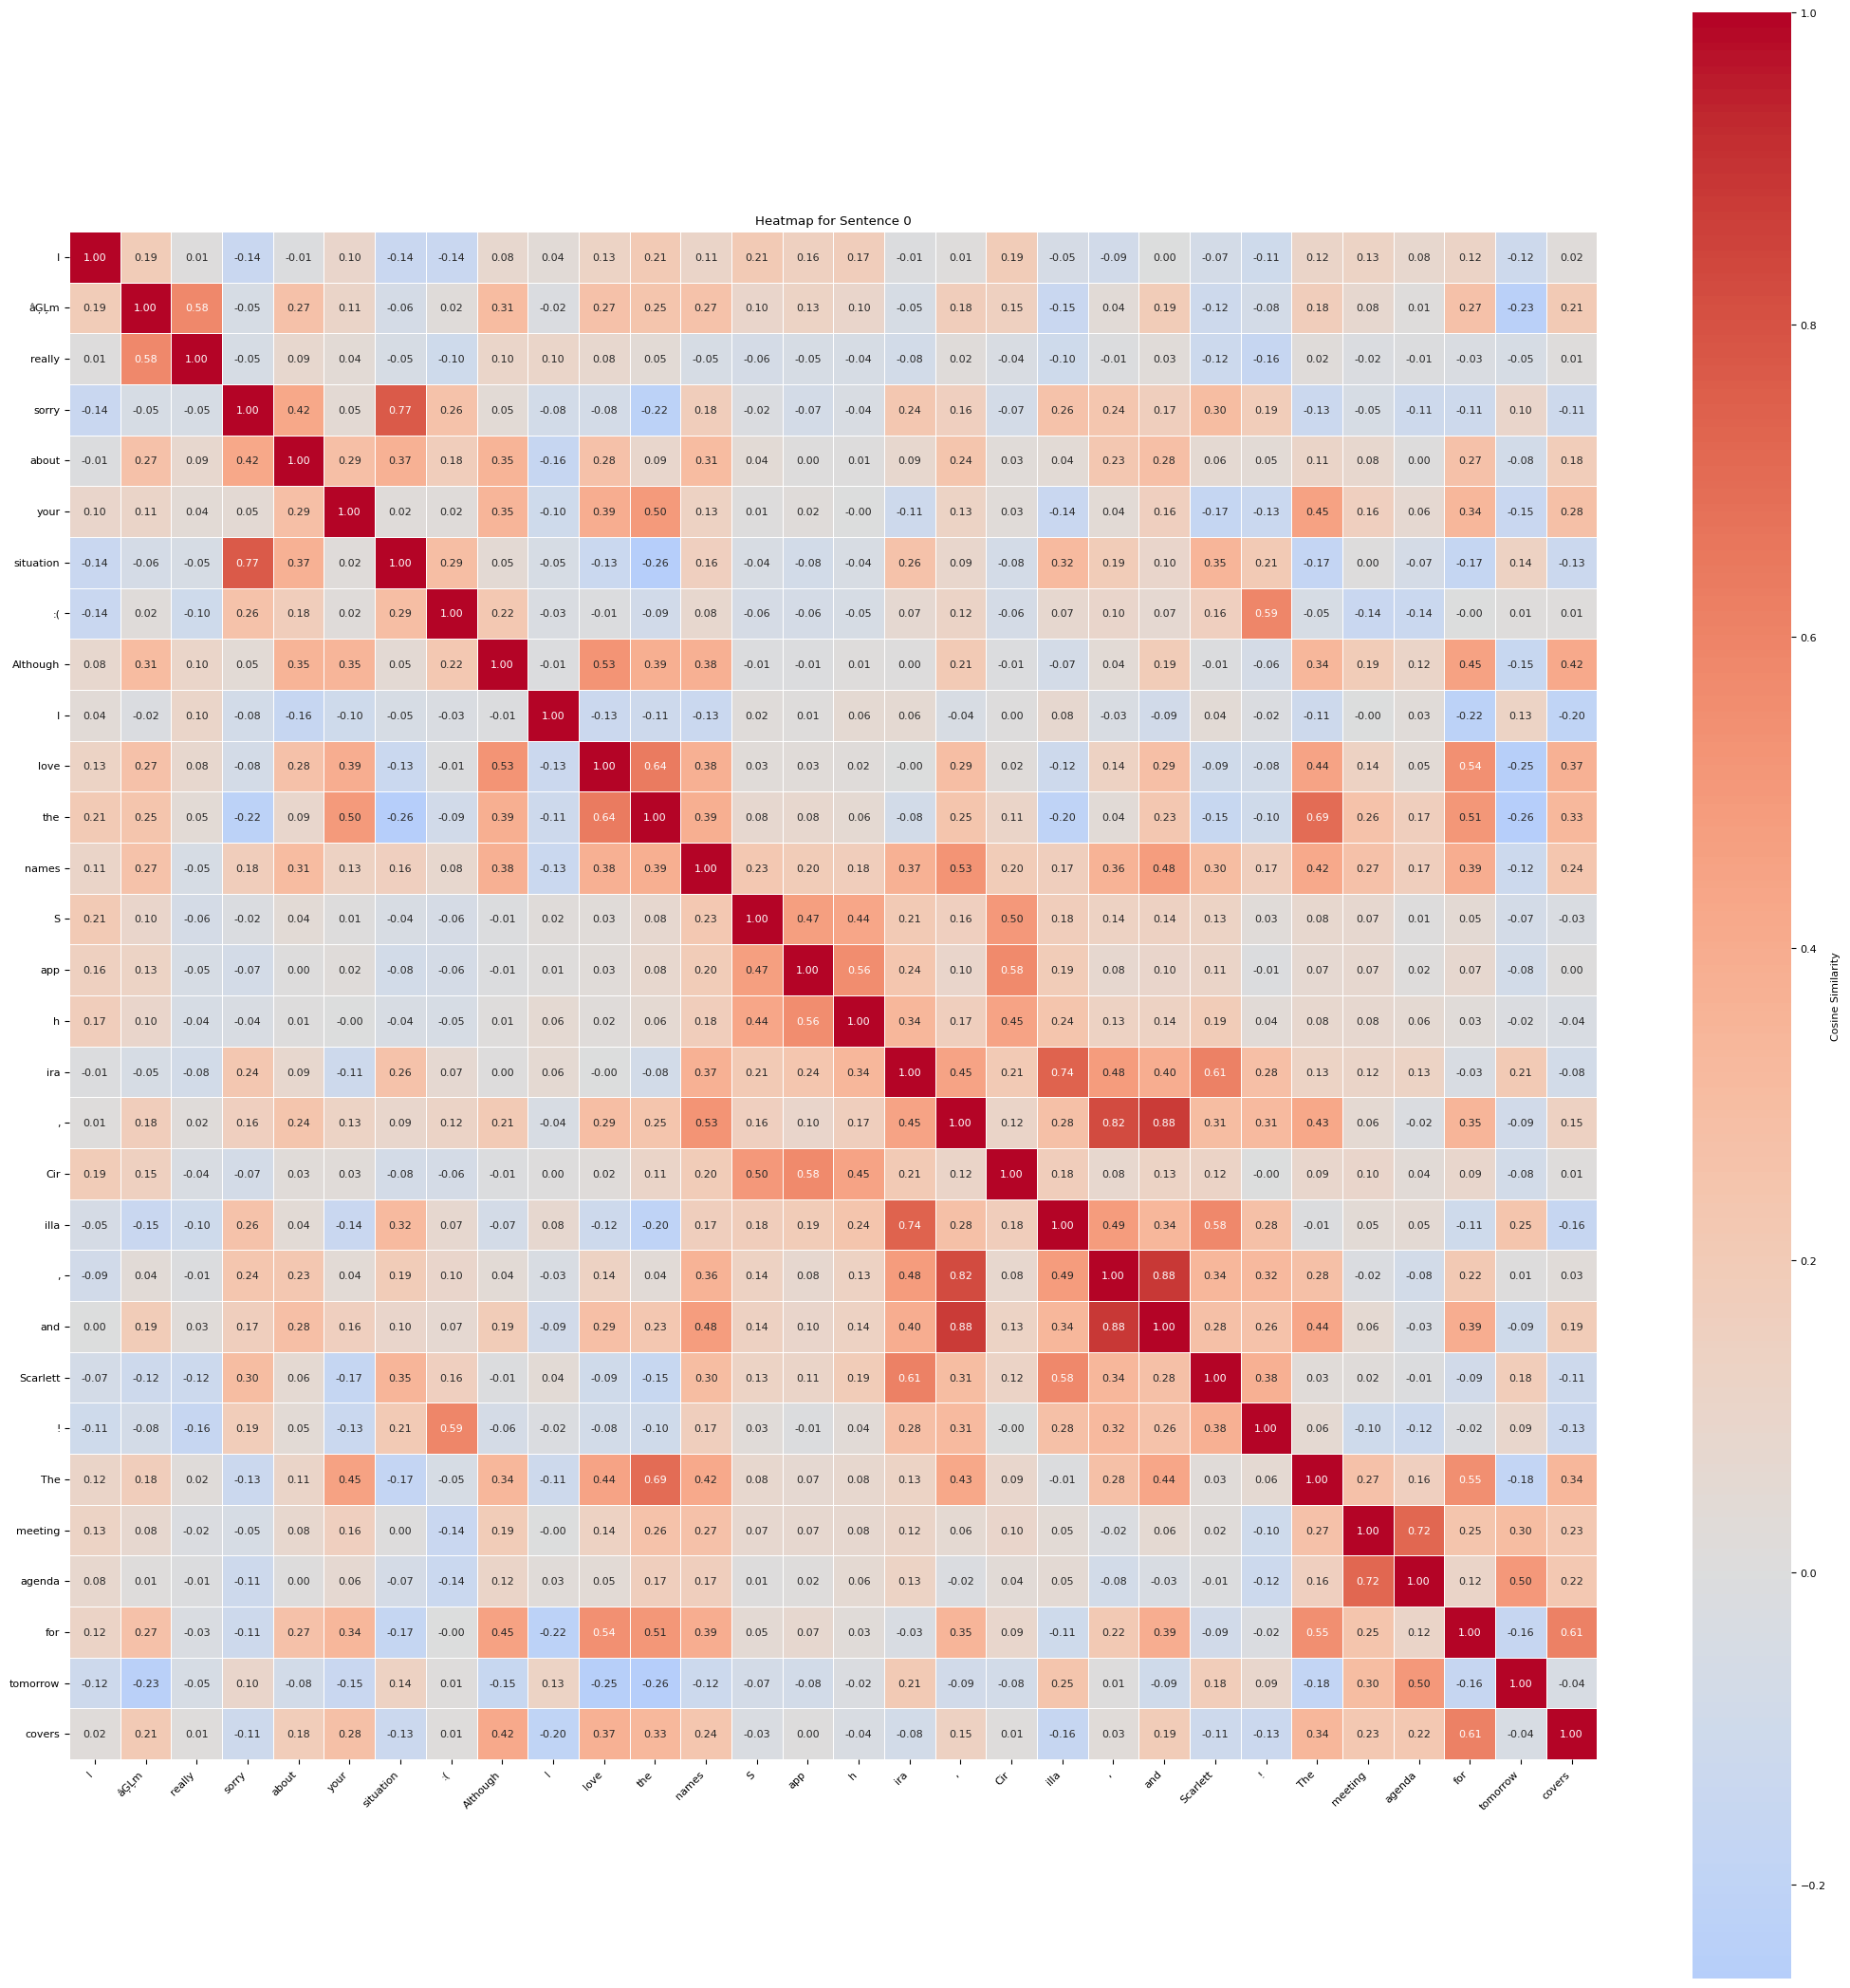

In [64]:
sentence_idx = 0
plot_sentence_similarity_heatmap(sentence_idx, tokens_list, embeds, max_tokens=30)

# Map each token to concept (of overall sentence)

In [19]:
# gt_results = map_sentence_to_concept_gt(DATASET_NAME, MODEL_INPUT_SIZE, one_indexed=True)

if SAMPLE_TYPE == 'cls':
    gt_samples_per_concept_train = torch.load(f'GT_Samples/{DATASET_NAME}/gt_samples_per_concept_train_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
    gt_samples_per_concept = torch.load(f'GT_Samples/{DATASET_NAME}/gt_samples_per_concept_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
else:
    gt_samples_per_concept_train = torch.load(f'GT_Samples/{DATASET_NAME}/gt_patch_per_concept_train_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)
    gt_samples_per_concept = torch.load(f'GT_Samples/{DATASET_NAME}/gt_patches_per_concept_inputsize_{MODEL_INPUT_SIZE}.pt', weights_only=False)

print_paragraph_or_sentence_gt_examples(DATASET_NAME, MODEL_INPUT_SIZE, num_examples=4)


=== Paragraph-Level GT Examples ===

Concept: admiration
[1] In some literature, paradoxes are used to make a point more effectively. It's wonderful because it's awful. At not with.
[13] It's great that you're a recovering addict, that's cool. Have you ever tried DMT? I read a thread about various therapeutic practices and their effectiveness.
[26] This guy is a little turd but I love him so dearly. I'll pass on your kisses :) After reorganizing my photo album, I found a picture that reminded me of it.
[39] in what universe? lol the mr. blue sky cover is one of the best on the album imo. I was browsing through some album reviews earlier and saw varied feedback on the tracks.

Concept: amusement
[11] Lol! But I love your last name though. XD It’s always fascinating to learn about the different meanings behind common last names.
[18] There's a thread discussing how quickly subscription service fees can add up over time. Triggered:: Welp guess it's time for me to re-up lol
[20] When brow

# Compute Concepts and cos sims

## Avg

In [65]:
CONCEPTS_FILE = f'avg_concepts_{MODEL_NAME}_{SAMPLE_TYPE}_embeddings_percentthrumodel_{PERCENT_THRU_MODEL}.pt'
COSSIM_FILE = f'cosine_similarities_{CONCEPTS_FILE[:-3]}.csv'
CON_LABEL = f"{MODEL_NAME}_avg_{SAMPLE_TYPE}_embeddings_percentthrumodel_{PERCENT_THRU_MODEL}"

# concepts = compute_avg_concept_vectors(gt_samples_per_concept_train, 
#                                            embeds, dataset_name=DATASET_NAME, 
#                                        output_file=CONCEPTS_FILE)
concepts = torch.load(f'Concepts/{DATASET_NAME}/{CONCEPTS_FILE}', weights_only=True)
curr_concepts = filter_concept_list(list(concepts.keys()), DATASET_NAME)

COSSIM_FILE = f'cosine_similarities_{CONCEPTS_FILE}'
# act_metrics = compute_cosine_sims(embeddings = embeds, 
#                     concepts = concepts, 
#                     output_file = COSSIM_FILE,
#                     dataset_name = DATASET_NAME,
#                     device = DEVICE,
#                     batch_size=256)

acts_loader = ChunkedActivationLoader(DATASET_NAME, COSSIM_FILE, SCRATCH_DIR)

UnpicklingError: Weights only load failed. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
 Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## linsep

In [20]:
BALANCE_DATA = True
BALANCE_NEGATIVES = False

CON_LABEL = f"{MODEL_NAME}_linsep_{SAMPLE_TYPE}_embeddings_BD_{BALANCE_DATA}_BN_{BALANCE_NEGATIVES}_percentthrumodel_{PERCENT_THRU_MODEL}"
CONCEPTS_FILE = f'linsep_concepts_BD_{BALANCE_DATA}_BN_{BALANCE_NEGATIVES}_{EMBEDDINGS_FILE}'
# concepts, logs = compute_linear_separators(embeds, gt_samples_per_concept, DATASET_NAME, 
#                                              sample_type=SAMPLE_TYPE, device=DEVICE, model_input_size=MODEL_INPUT_SIZE,
#                                              output_file=CONCEPTS_FILE, batch_size=64,
#                                              lr=0.001, epochs=1000, patience=20, tolerance=0.001,
#                                              weight_decay=0.0001, lr_step_size=5, lr_gamma=0.8,
#                                              balance_data=BALANCE_DATA,
#                                              balance_negatives=BALANCE_NEGATIVES)

concepts = torch.load(f'Concepts/{DATASET_NAME}/{CONCEPTS_FILE}', weights_only=True)
curr_concepts = filter_concept_list(list(concepts.keys()), DATASET_NAME)

DISTS_FILE = f'dists_{CONCEPTS_FILE}'
# act_metrics = compute_signed_distances(embeds, concepts, DATASET_NAME, 
#                                        output_file=DISTS_FILE, device=DEVICE, scratch_dir='')

acts_loader = ChunkedActivationLoader(DATASET_NAME, DISTS_FILE, SCRATCH_DIR, DEVICE)

### show training plots

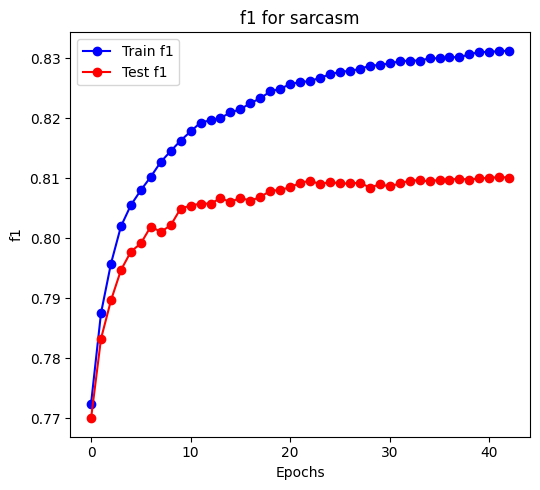

In [28]:
logs = torch.load(f'Concepts/{DATASET_NAME}/logs_{CONCEPTS_FILE}', weights_only=False)
plot_train_history(logs, metric_type='f1')  

# Misc

In [15]:
from utils.text_visualization_utils import filter_and_print_concept_texts
filter_and_print_concept_texts(
  metadata_path=f'../Data/{DATASET_NAME}/metadata.csv',
  required_concepts=['sarcastic'],
  dataset_name=DATASET_NAME,
  tokens_list=tokens_list,
  gt_samples_per_concept=gt_samples_per_concept,
  n_texts=10000,
  start_idx=0,
  chosen_split='test'
)

Found 178 texts matching concepts: ['sarcastic']
Showing 178 texts from index 0

Debug - Available concepts in gt_samples_per_concept: ['irony', 'overstatement', 'rhetorical_question', 'sarcasm', 'sarcastic', 'satire', 'understatement']
  - 'sarcastic' has 20800 GT token indices


# Quant Analysis

## heatmaps

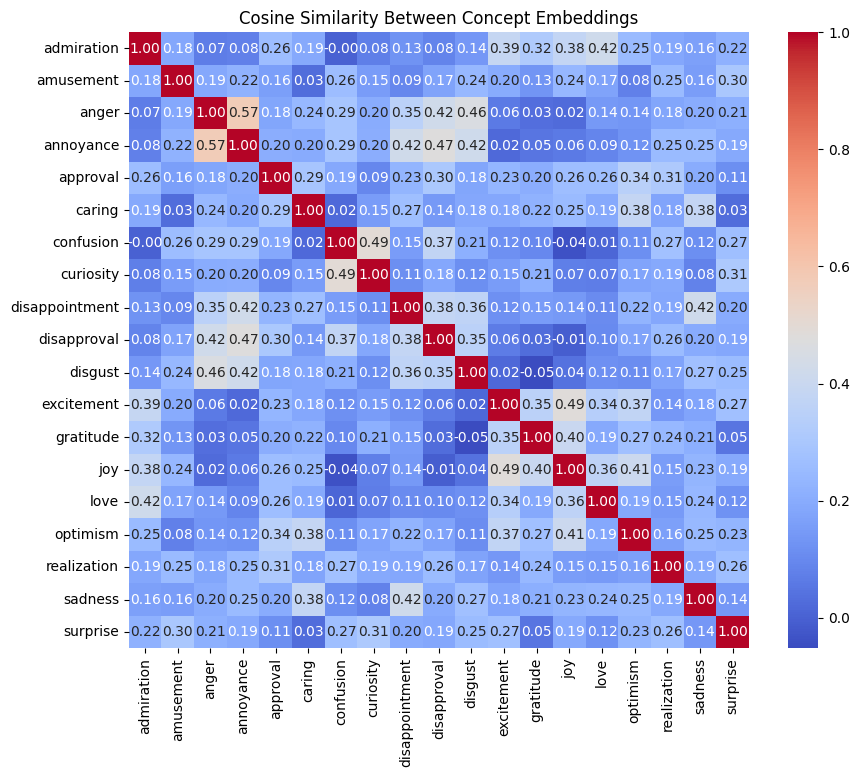

In [17]:
concept_heatmap(concepts, con_label=CON_LABEL, dataset_name=DATASET_NAME, normalize=True)

## histograms

In [35]:
stats, optimal_thresholds, pr_curves = compute_cossim_hist_stats(
      gt_samples_per_concept=gt_samples_per_concept,
      acts_loader=acts_loader,
      dataset_name=DATASET_NAME,
      percentile=None,
      sample_type=SAMPLE_TYPE,
      model_input_size=MODEL_INPUT_SIZE,
      con_label=None,
      patch_size=14,
      all_object_patches=None,
      concepts_to_process=curr_concepts,
      device=DEVICE
      )

Processing chunks: 100% 1/1 [00:00<00:00,  1.90it/s]


/tmp/ipykernel_5829/2858707188.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt')


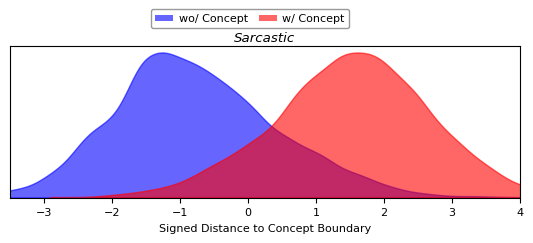

In [38]:
#Plot Histograms
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt')
plot_cosine_similarity_histograms(stats, all_thresholds, plot_type='test', sample_type=SAMPLE_TYPE, 
                                  percentile=None, optimal_thresholds=None,
                                  xlabel="Signed Distance to Concept Boundary", f1_text_side='left',
                                 concepts = curr_concepts, bins=50, vmin=-3.5, vmax=4,
                                 save_path=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_{SAMPLE_TYPE}_hist_optimal.pdf')

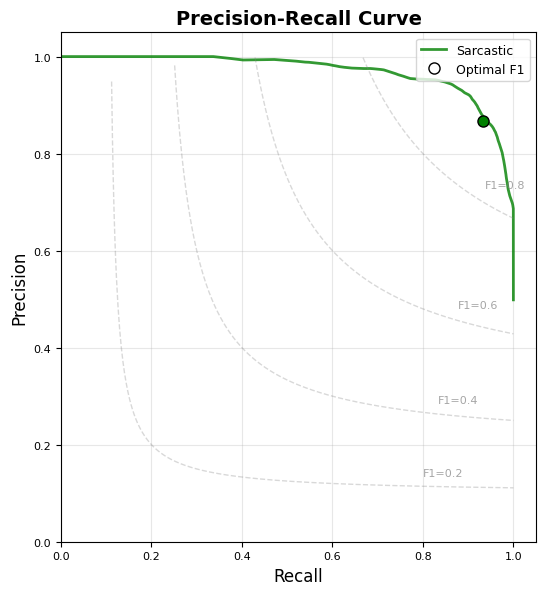

In [144]:
plot_precision_recall_curves_overlay(
      pr_curves=pr_curves,
      optimal_thresholds=optimal_thresholds,
      concepts=curr_concepts, 
      split='test',
      show_random_baseline=False,
      save_path=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_{SAMPLE_TYPE}_prcurves_overlay.pdf'
  )

# Visualize Concepts

## Most aligned tokens/sentences w a given concept

Select a concept from the list below:
0: sarcasm


Enter the number corresponding to the concept:  0



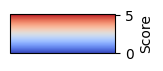

In [18]:
if SAMPLE_TYPE == 'patch':
    plot_most_aligned_tokens(acts_loader, tokens_list, DATASET_NAME, top_k=30)
else:
    plot_most_aligned_sentences(acts_loader, all_text, DATASET_NAME, top_k=5, split='test')

## Most aligned tokens in context of larger sentences

Select a concept from the list below:
0: sarcasm


Enter the number corresponding to the concept:  0



Plotting paragraphs MOST activated by sarcasm (max over tokens)




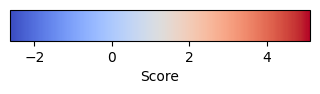

In [27]:
plot_tokens_in_context_byconcept(acts_loader, tokens_list, DATASET_NAME, concept=None, top_k=5, 
                                 top=True, aggr_method='max', split='test')

## Most, Least, and Neutral Aligned Tokens in Context

Select a concept from the list below:
0: irony
1: overstatement
2: rhetorical_question
3: sarcasm
4: sarcastic
5: satire
6: understatement


Enter the number corresponding to the concept:  4



Concept: sarcastic
GT True paragraphs in test set: 171
GT False paragraphs in test set: 178
Activation range: [-4.652, 7.139]



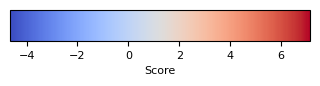

In [221]:
plot_tokens_by_activation_and_gt(acts_loader, tokens_list, DATASET_NAME, MODEL_INPUT_SIZE, n_examples=3)

## Show All Concept Activations on a Sentence

In [13]:
from utils.text_visualization_utils import plot_all_concept_activations_on_sentence
n_indices = 1
# sentence_indices = retrieve_topn_samples(DATASET_NAME, n_indices, start_idx=idx, split='test')
sentence_indices = [1712, 170, 860, 1142, 984]
sentence_indices=[3003]

sentence_indices = [4740, 3852, 1586, 1741, 1805]
sentence_indices = 1805
# # for sentence_idx in range(10):
for sentence_idx in sentence_indices:
    plot_all_concept_activations_on_sentence(sentence_idx, acts_loader, tokens_list, DATASET_NAME, 
                                                 gt_samples_per_concept=gt_samples_per_concept,
                                             vmin=-2, vmax=2)

IndexError: list index out of range

## Text Gradient

In [34]:
# iSarcasm: 1150, 1712, 170, 860, 1142, 984
# Setup parameters
sentence_idx = 1150 # Choose which sentence to visualize
sentence_idx = 2965
concept = 'anger'    # Choose which concept to visualize

# Load thresholds - assuming you have them saved
percentiles = [0.9, 0.7, 0.4]
thresholds_dict = {}
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
for percentile in percentiles:
  thresholds_dict[percentile] = all_thresholds[percentile][concept][0]  # Get threshold for this concept

# Call the function
plot_binarized_token_activations_with_raw_heatmap(
  sentence_idx=sentence_idx,
  concept=concept,
  act_loader=acts_loader, 
  tokens_list=tokens_list, 
  dataset_name=DATASET_NAME,
  thresholds_dict=thresholds_dict,
  gt_samples_per_concept=gt_samples_per_concept,
  vmin=None,  # Optional: set color scale limits
  vmax=None,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_text_gradient_example_{sentence_idx}_{concept}.pdf'
)

KeyError: 'anger'

## Multiple Concepts

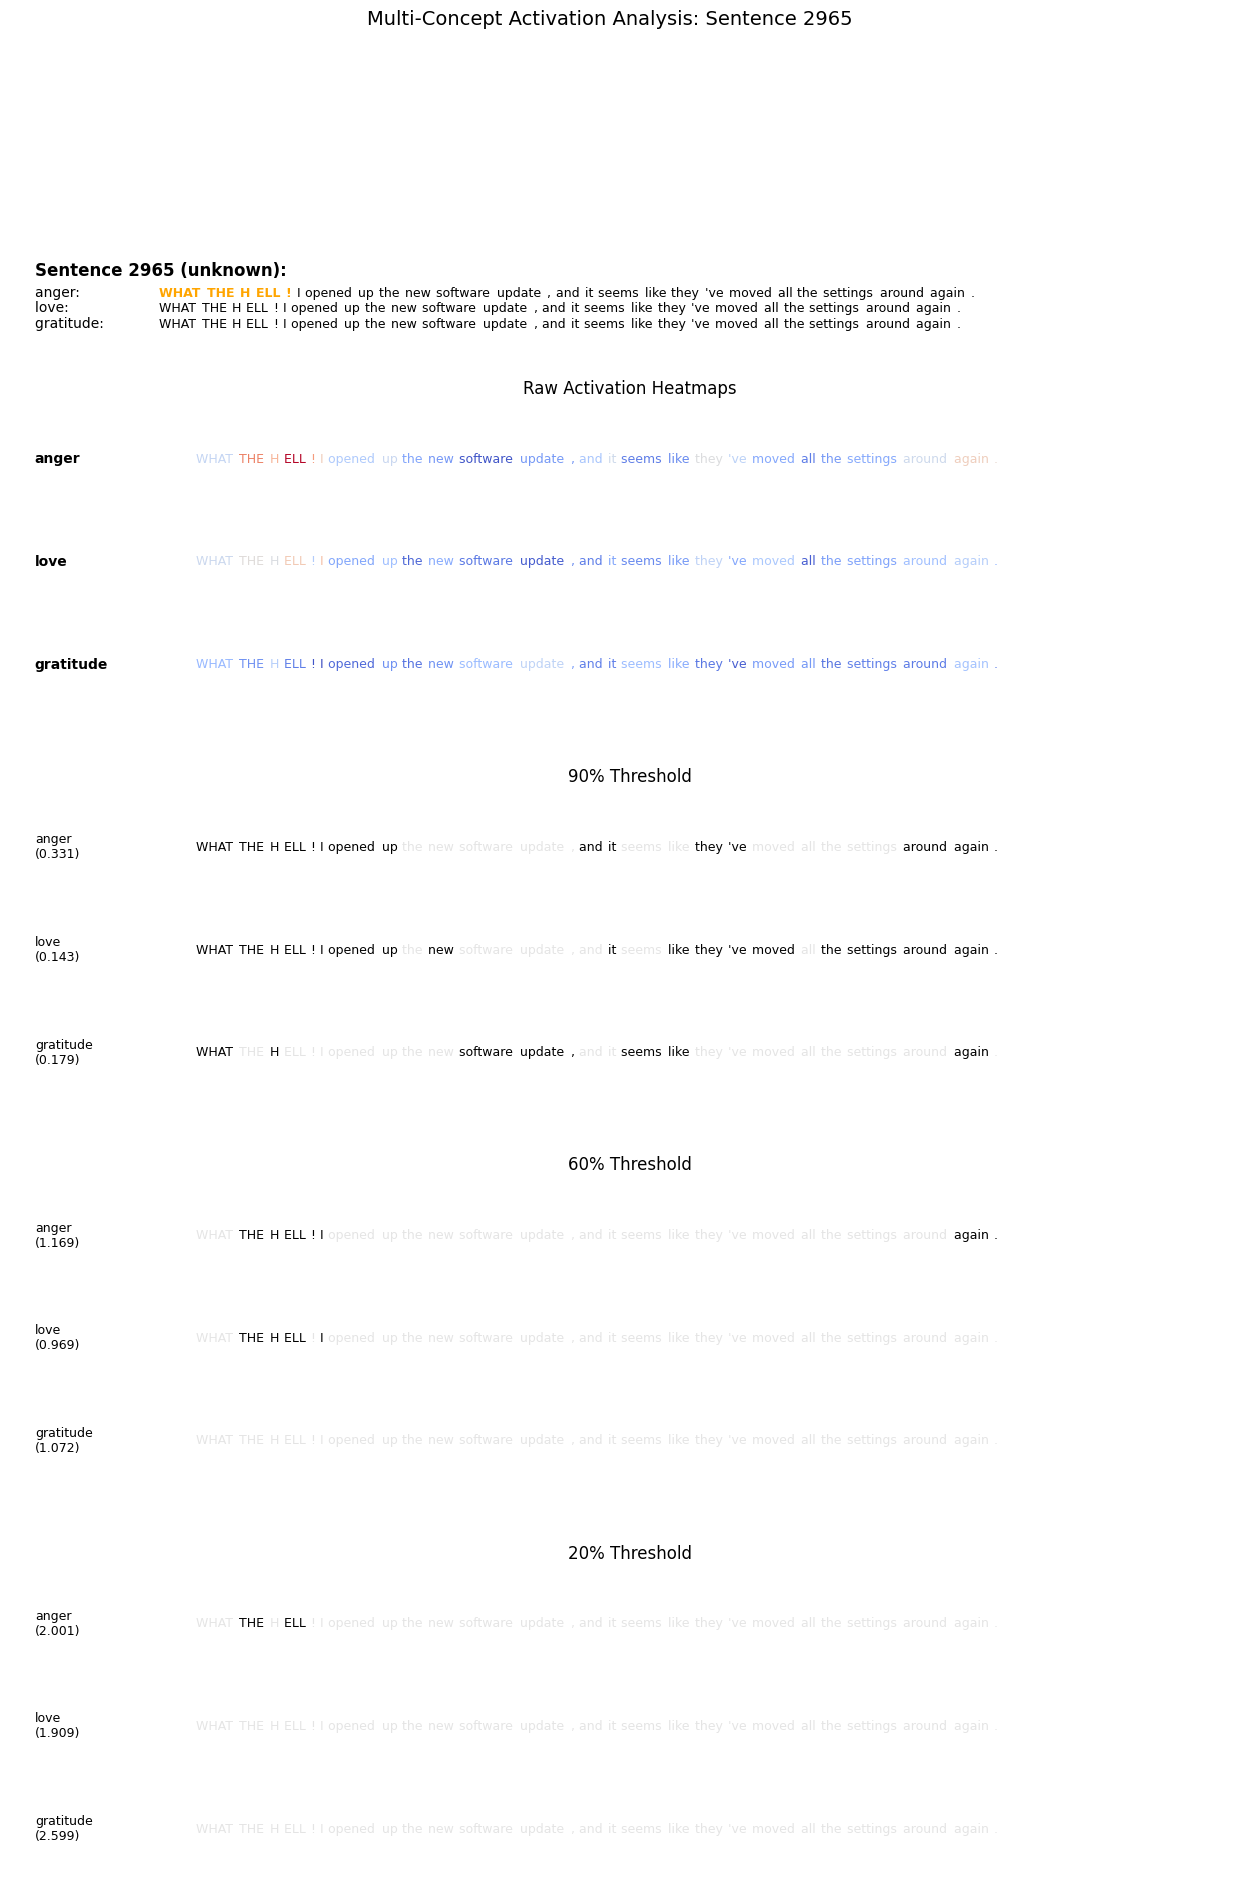

In [127]:
# Setup parameters
# sentence_idx = 3414  # Choose which sentence to visualize
# curr_concepts = ['sadness', 'anger', 'joy']  # Multiple concepts

sentence_idx = 1741 #
# sentence_idx = 1268
# curr_concepts = ['disgust', 'sadness', 'love']
sentence_idx = 2965
curr_concepts = ['anger', 'love', 'gratitude']

# Load thresholds
percentiles = [0.9, 0.6, 0.2]  # Which percentiles to show
thresholds_dict = {}
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
for percentile in percentiles:
  thresholds_dict[percentile] = all_thresholds[percentile]

# Call the function
plot_binarized_multiconcept_text(
  sentence_idx=sentence_idx,
  concepts=curr_concepts,
  act_loader=acts_loader,
  tokens_list=tokens_list,
  dataset_name=DATASET_NAME,
  thresholds_dict=thresholds_dict,
  gt_samples_per_concept=gt_samples_per_concept,
  percentiles_to_show=percentiles,  # Optional: specify which percentiles to show
  vmin=None,  # Optional: set color scale limits
  vmax=None,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_multiconcept_gradient_{sentence_idx}.pdf',
  show_colorbar_ticks=False
)

# Show Superpatches

In [35]:
idx = 2965
curr_concepts = ['anger', 'love', 'gratitude']
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
best_detect_percentiles = torch.load(f'Best_Detection_Percentiles_Cal/{DATASET_NAME}/best_percentiles_{CON_LABEL}.pt', weights_only=True)
for concept in curr_concepts:
    print(concept, ":", best_detect_percentiles[concept])

if 'avg' in CONCEPTS_FILE:
  metric_type = 'Cosine Similarity to Concept'
  vmin=-0.5
  vmax=0.6
else:
  metric_type = 'Signed Distance to Concept Boundary'
  vmin=-1
  vmax= 3
    
concept_to_thresholds = {concept: all_thresholds[best_detect_percentiles[concept]['best_percentile']][concept][0] for concept in curr_concepts}
plot_multi_concept_heatmaps(
  sentence_idx=idx,
  main_concept="anger",
  additional_concepts=['love', 'sadness'],
  act_loader=acts_loader,
  tokens_list=tokens_list,
  dataset_name=DATASET_NAME,
  gt_samples_per_concept=gt_samples_per_concept,
  thresholds_dict=concept_to_thresholds,
  vmin=vmin, vmax=vmax,
  metric_type=metric_type,
  show_colorbar_ticks=False,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_supertoken_example_{sentence_idx}_{CONCEPTS_FILE}.pdf',
  figsize=(15, 6)
)

KeyError: 'anger'

In [26]:
import utils.plot_text_heatmap_reportlab_v2
importlib.reload(utils.plot_text_heatmap_reportlab_v2)
from utils.plot_text_heatmap_reportlab_v2 import plot_multi_concept_heatmaps_reportlab

idx = 1805
curr_concepts = ['joy']

all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
best_detect_percentiles = torch.load(f'Best_Detection_Percentiles_Cal/{DATASET_NAME}/best_percentiles_{CON_LABEL}.pt', weights_only=True)
for concept in curr_concepts:
    print(concept, ":", best_detect_percentiles[concept])
if 'avg' in CONCEPTS_FILE:
  metric_type = 'Cosine Similarity to Concept'
  vmin=-0.5
  vmax=0.6
else:
  metric_type = 'Signed Distance to Concept Boundary'
  vmin=-1.8
  vmax= 4
    
concept_to_thresholds = {concept: all_thresholds[best_detect_percentiles[concept]['best_percentile']][concept][0] for concept in curr_concepts}

plot_multi_concept_heatmaps_reportlab(
  sentence_idx=idx,
  main_concept=curr_concepts[0],
  additional_concepts=[],
  act_loader=acts_loader,
  tokens_list=tokens_list,
  thresholds_dict=concept_to_thresholds,
  dataset_name=DATASET_NAME,
  metric_type=metric_type,
  gt_samples_per_concept=gt_samples_per_concept,
  vmin=vmin, vmax=vmax,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_supertoken_example_{idx}_{CONCEPTS_FILE}.pdf',
  show_cbar=False,
  text_font_size=11,
  header_font_size=12,
  figure_width=5.5,
  heatmap_alpha=0.7
)

joy : {'best_percentile': 0.05, 'best_f1': 0.35135135135135137, 'best_threshold': 2.3870301246643066}
Processing sentence 1805 with 29 tokens

PDF saved successfully!
Location: /path/to/concept_inversion/Figs/Paper_Figs/Qwen_GoEmotions_supertoken_example_1805_linsep_concepts_BD_True_BN_False_Qwen_patch_embeddings_percentthrumodel_100.pt.pdf


'../Figs/Paper_Figs/Qwen_GoEmotions_supertoken_example_1805_linsep_concepts_BD_True_BN_False_Qwen_patch_embeddings_percentthrumodel_100.pt.pdf'

In [18]:
import utils.plot_text_heatmap_reportlab_v2
importlib.reload(utils.plot_text_heatmap_reportlab_v2)
from utils.plot_text_heatmap_reportlab_v2 import plot_multi_concept_heatmaps_reportlab_single_line

idx = 2965
idx=193
curr_concepts = ['anger', 'love', 'gratitude']
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
best_detect_percentiles = torch.load(f'Best_Detection_Percentiles_Cal/{DATASET_NAME}/best_percentiles_{CON_LABEL}.pt', weights_only=True)
for concept in curr_concepts:
    print(concept, ":", best_detect_percentiles[concept])

if 'avg' in CONCEPTS_FILE:
  metric_type = 'Cosine Similarity to Concept'
  vmin=-0.5
  vmax=0.6
else:
  metric_type = 'Signed Distance to Concept Boundary'
  vmin=-1
  vmax= 3
    
concept_to_thresholds = {concept: all_thresholds[best_detect_percentiles[concept]['best_percentile']][concept][0] for concept in curr_concepts}

plot_multi_concept_heatmaps_reportlab_single_line(
  sentence_idx=idx,
  main_concept="admiration",
  additional_concepts=[],
  act_loader=acts_loader,
  tokens_list=tokens_list,
  thresholds_dict=concept_to_thresholds,
  dataset_name=DATASET_NAME,
  metric_type=metric_type,
  gt_samples_per_concept=gt_samples_per_concept,
  vmin=vmin, vmax=vmax,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_supertoken_example_{idx}_{CONCEPTS_FILE}.pdf',
  show_cbar=False,
  text_font_size=8,
  header_font_size=10,
  figure_width=5.5,
  heatmap_alpha=0.7
)

ModuleNotFoundError: No module named 'reportlab'

In [14]:
import utils.plot_text_heatmap_reportlab_v2
importlib.reload(utils.plot_text_heatmap_reportlab_v2)
from utils.plot_text_heatmap_reportlab_v2 import plot_multi_concept_heatmaps_reportlab_single_line

idx = 1150
idx = 1712
curr_concepts = ['sarcastic']
all_thresholds = torch.load(f'Thresholds/{DATASET_NAME}/all_percentiles_{CON_LABEL}.pt', weights_only=True)
best_detect_percentiles = torch.load(f'Best_Detection_Percentiles_Cal/{DATASET_NAME}/best_percentiles_{CON_LABEL}.pt', weights_only=True)
for concept in curr_concepts:
    print(concept, ":", best_detect_percentiles[concept])

if 'avg' in CONCEPTS_FILE:
  metric_type = 'Cosine Similarity to Concept'
  vmin=-0.5
  vmax=0.6
else:
  metric_type = 'Signed Distance to Concept Boundary'
  vmin=-1
  vmax= 3
    
concept_to_thresholds = {concept: all_thresholds[best_detect_percentiles[concept]['best_percentile']][concept][0] for concept in curr_concepts}

plot_multi_concept_heatmaps_reportlab_single_line(
  sentence_idx=idx,
  main_concept="sarcastic",
  additional_concepts=[],
  act_loader=acts_loader,
  tokens_list=tokens_list,
  thresholds_dict=concept_to_thresholds,
  dataset_name=DATASET_NAME,
  metric_type=metric_type,
  gt_samples_per_concept=gt_samples_per_concept,
  vmin=vmin, vmax=vmax,
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_supertoken_example_{idx}_{CONCEPTS_FILE}.pdf',
  show_cbar=False,
  text_font_size=8,
  header_font_size=10,
  figure_width=5.5,
  heatmap_alpha=0.7
)

sarcastic : {'best_percentile': 0.3, 'best_f1': 0.915151515151515, 'best_threshold': 2.068305015563965}
Processing sentence 1712 with 31 tokens

PDF saved successfully!
Location: /path/to/concept_inversion/Figs/Paper_Figs/Llama_iSarcasm_supertoken_example_1712_linsep_concepts_BD_True_BN_False_Llama_patch_embeddings_percentthrumodel_100.pt.pdf


'../Figs/Paper_Figs/Llama_iSarcasm_supertoken_example_1712_linsep_concepts_BD_True_BN_False_Llama_patch_embeddings_percentthrumodel_100.pt.pdf'

In [15]:
import utils.plot_text_heatmap_reportlab_v2
importlib.reload(utils.plot_text_heatmap_reportlab_v2)
from utils.plot_text_heatmap_reportlab_v2 import plot_simple_concept_heatmap_reportlab

idx = 1712

if 'avg' in CONCEPTS_FILE:
  metric_type = 'Cosine Similarity to Concept'
  vmin=-0.5
  vmax=0.6
else:
  metric_type = 'Signed Distance to Concept Boundary'
  vmin=-2
  vmax= 2
    
# Example call with all arguments
plot_simple_concept_heatmap_reportlab(
  sentence_idx=idx,  # Index of the sentence to visualize (0-based)
  main_concept='sarcastic',  # The concept to visualize (e.g., 'positive', 'negative', 'sarcasm')
  act_loader=acts_loader,  # Your activation loader object (from compute_activations.py)
  tokens_list=tokens_list,  # List of tokenized sentences (list of lists of tokens)
  dataset_name=DATASET_NAME,  # Dataset name (e.g., 'imdb', 'sarcasm', 'isarcasm')
  gt_samples_per_concept=gt_samples_per_concept,  # Dict mapping concepts to lists of token indices that are ground truth
  cmap_name='coolwarm',  # Matplotlib colormap name ('magma', 'viridis', 'plasma', 'inferno', 'cividis', etc.)
  vmin=vmin,  # Minimum value for colormap normalization (None for auto)
  vmax=vmax,  # Maximum value for colormap normalization (None for auto)
  save_file=f'../Figs/Paper_Figs/{MODEL_NAME}_{DATASET_NAME}_heatmap_example_{idx}_{CONCEPTS_FILE}.pdf',  
  metric_type=metric_type,  # Label for the colorbar
  show_cbar=False,
  show_superdetectors=False,
  text_font_size=8,
  header_font_size=10,
  figure_width=2.75,
  heatmap_alpha=0.7
  
)

Processing sentence 1712 with 31 tokens

Concept 'sarcastic' activation statistics:
  Min: -0.8180
  Max: 2.2556
  Mean: 0.8375
  Std: 0.8984

Colormap 'coolwarm' range:
  vmin: -2.0000
  vmax: 2.0000

PDF saved successfully!
Location: /path/to/concept_inversion/Figs/Paper_Figs/Llama_iSarcasm_heatmap_example_1712_linsep_concepts_BD_True_BN_False_Llama_patch_embeddings_percentthrumodel_100.pt.pdf


'../Figs/Paper_Figs/Llama_iSarcasm_heatmap_example_1712_linsep_concepts_BD_True_BN_False_Llama_patch_embeddings_percentthrumodel_100.pt.pdf'

# Extraas

In [26]:
from termcolor import colored

def highlight_tokens(text, target_tokens):
    tokens = text.split()
    highlighted = [colored(tok, 'cyan', attrs=['bold']) if tok in target_tokens else tok for tok in tokens]
    return ' '.join(highlighted)

# Example
text = "the quick brown fox jumps over the lazy dog"
target_tokens = ['quick', 'lazy']
print(highlight_tokens(text, target_tokens))


the quick brown fox jumps over the lazy dog


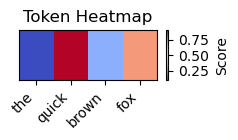

In [27]:
import matplotlib.pyplot as plt

def plot_token_heatmap(tokens, scores, title="Token Heatmap"):
    plt.figure(figsize=(len(tokens) * 0.6, 1.5))
    plt.imshow([scores], cmap="coolwarm", aspect="auto")
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.yticks([])
    plt.colorbar(label="Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example
tokens = ["the", "quick", "brown", "fox"]
scores = [0.1, 0.9, 0.3, 0.7]
plot_token_heatmap(tokens, scores)


In [28]:
from IPython.display import display, HTML

def highlight_tokens_html(tokens, scores, cmap='coolwarm'):
    import matplotlib
    norm = matplotlib.colors.Normalize(vmin=min(scores), vmax=max(scores))
    cmap = matplotlib.cm.get_cmap(cmap)

    html = ""
    for token, score in zip(tokens, scores):
        color = matplotlib.colors.rgb2hex(cmap(norm(score)))
        html += f'<span style="background-color:{color}; padding:2px 4px; margin:2px; border-radius:3px;">{token}</span> '
    return HTML(html)

# Example
tokens = ["the", "quick", "brown", "fox"]
scores = [0.1, 0.9, 0.3, 0.7]
display(highlight_tokens_html(tokens, scores))

/tmp/ipykernel_1893/431742578.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


/tmp/ipykernel_1893/94089280.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)



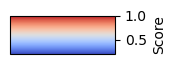

In [227]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import io
import base64

def get_colormap_color(score, cmap, norm):
    return matplotlib.colors.rgb2hex(cmap(norm(score)))

def plot_colorbar(vmin=0.0, vmax=1.0, cmap_name="coolwarm", orientation="vertical"):
    if orientation not in {"vertical", "horizontal"}:
        raise ValueError("orientation must be 'vertical' or 'horizontal'")

    figsize = (1.5, 0.5) if orientation == "vertical" else (5, 0.4)

    fig, ax = plt.subplots(figsize=figsize)
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    fig.subplots_adjust(left=0.2 if orientation == "vertical" else 0.3)
    cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation=orientation)
    cb.set_label("Score")

    # Convert plot to base64 for embedding
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    b64_img = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)

    return f'<img src="data:image/png;base64,{b64_img}" style="margin-top:10px; max-width:100%;" />'


def highlight_tokens_with_legend(tokens, scores, cmap_name="coolwarm"):
    # Normalize scores and get colormap
    norm = matplotlib.colors.Normalize(vmin=min(scores), vmax=max(scores))
    cmap = cm.get_cmap(cmap_name)

    html = ""
    for token, score in zip(tokens, scores):
        color = get_colormap_color(score, cmap, norm)
        html += f'<span style="background-color:{color}; padding:2px 4px; margin:2px; border-radius:3px;">{token}</span> '

    colorbar_html = plot_colorbar(vmin=min(scores), vmax=max(scores), cmap_name=cmap_name)

    full_html = f"""
    <div style="display: flex; align-items: flex-start;">
        <div style="flex: 1;">{html}</div>
        <div style="padding-left: 20px;">{colorbar_html}</div>
    </div>
    """
    return HTML(full_html)

tokens = ["the", "quick", "brown", "fox", "jumps", "over", "lazy", "dog"]
scores = [0.2, 0.95, 0.4, 0.8, 0.3, 0.5, 1.0, 0.25]

display(highlight_tokens_with_legend(tokens, scores))


In [34]:
def mark_tokens(text, token_list):
    for tok in token_list:
        text = text.replace(tok, f"<mark>{tok}</mark>")
    return HTML(f"<p>{text}</p>")

text = "The quick brown fox jumps over the lazy dog"
highlighted = mark_tokens(text, ["quick", "lazy"])
display(highlighted)
